# 2023-09-15 Advection

## Last time

* Variable coefficients
* Conservative/divergence form vs non-divergence forms
* Verification with discontinuities

## Today

* Advection and boundary layers
* The (cell) Péclet number and oscillations
* Godunov's Theorem

In [3]:
using Plots
default(linewidth=3)
using LinearAlgebra

function vander(x, k=nothing)
    if k === nothing
        k = length(x)
    end
    V = ones(length(x), k)
    for j = 2:k
        V[:, j] = V[:, j-1] .* x
    end
    V
end

function fdstencil(source, target, k)
    "kth derivative stencil from source to target"
    x = source .- target
    V = vander(x)
    rhs = zero(x)'
    rhs[k+1] = factorial(k)
    rhs / V
end

function my_spy(A)
    cmax = norm(vec(A), Inf)
    s = max(1, ceil(120 / size(A, 1)))
    spy(A, marker=(:square, s), c=:diverging_rainbow_bgymr_45_85_c67_n256, clims=(-cmax, cmax))
end

function poisson_nondivergence(n, kappa, forcing; leftbc=(0, zero), rightbc=(0, zero), spoints=3)
    x = LinRange(-1, 1, n)
    L = zeros(n, n)
    rhs = forcing.(x)
    kappax = kappa.(x)
    for i in 2:n-1
        jleft = min(max(1, i-spoints÷2), n-spoints+1)
        js = jleft : jleft + spoints - 1
        kappa_x = fdstencil(x[js], x[i], 1) * kappax[js]
        L[i, js] = -fdstencil(x[js], x[i], 2) .* kappax[i] - fdstencil(x[js], x[i], 1) * kappa_x
    end
    L[1,1:spoints] = fdstencil(x[1:spoints], x[1], leftbc[1])
    if leftbc[1] == 1
        L[1, :] *= kappax[1]
    end
    L[n,n-spoints+1:n] = fdstencil(x[n-spoints+1:n], x[n], rightbc[1])
    if rightbc[1] == 1
        L[n, :] *= kappax[n]
    end
    rhs[1] = leftbc[2](x[1])
    rhs[n] = rightbc[2](x[n])
    x, L, rhs
end

function poisson_conservative(n, kappa, forcing; leftbc=(0, zero), rightbc=(0, zero))
    x = LinRange(-1, 1, n)
    xstag = (x[1:end-1] + x[2:end]) / 2
    L = zeros(n, n)
    rhs = forcing.(x)
    kappa_stag = kappa.(xstag)
    for i in 2:n-1
        flux_L = kappa_stag[i-1] * fdstencil(x[i-1:i], xstag[i-1], 1)
        flux_R = kappa_stag[i] * fdstencil(x[i:i+1], xstag[i], 1)
        js = i-1:i+1
        weights = -fdstencil(xstag[i-1:i], x[i], 1)
        L[i, i-1:i+1] = weights[1] * [flux_L..., 0] + weights[2] * [0, flux_R...]
    end
    if leftbc[1] == 0
        L[1, 1] = 1
        rhs[1] = leftbc[2](x[1])
        rhs[2:end] -= L[2:end, 1] * rhs[1]
        L[2:end, 1] .= 0
    end
    if rightbc[1] == 0
        L[end,end] = 1
        rhs[end] = rightbc[2](x[end])
        rhs[1:end-1] -= L[1:end-1,end] * rhs[end]
        L[1:end-1,end] .= 0
    end
    x, L, rhs
end
    
    
CosRange(a, b, n) = (a + b)/2 .+ (b - a)/2 * cos.(LinRange(-pi, 0, n))
function vander_chebyshev(x, n=nothing)
    if isnothing(n)
        n = length(x) # Square by default
    end
    m = length(x)
    T = ones(m, n)
    if n > 1
        T[:, 2] = x
    end
    for k in 3:n
        T[:, k] = 2 * x .* T[:,k-1] - T[:, k-2]
    end
    T
end

function chebdiff(x, n=nothing)
    T = vander_chebyshev(x, n)
    m, n = size(T)
    dT = zero(T)
    dT[:,2:3] = [one.(x) 4*x]
    for j in 3:n-1
        dT[:,j+1] = j * (2 * T[:,j] + dT[:,j-1] / (j-2))
    end
    ddT = zero(T)
    ddT[:,3] .= 4
    for j in 3:n-1
        ddT[:,j+1] = j * (2 * dT[:,j] + ddT[:,j-1] / (j-2))
    end
    T, dT, ddT
end

function my_spy(A)
    cmax = norm(vec(A), Inf)
    s = max(1, ceil(120 / size(A, 1)))
    spy(A, marker=(:square, s), c=:diverging_rainbow_bgymr_45_85_c67_n256, clims=(-cmax, cmax))
end


my_spy (generic function with 1 method)

# Solving with the smoothed step $\kappa$

In [8]:
manufactured(x) = tanh(2x)
d_manufactured(x) = 2*cosh(2x)^-2
mdd_manufactured(x) = 8 * tanh(2x) / cosh(2x)^2
kappa_tanh(x, epsilon=.02)= .55 + .45 * tanh(x / epsilon)
d_kappa_tanh(x, epsilon=.02) = .45/epsilon * cosh(x/epsilon)^-2
flux_manufactured_kappa_tanh(x) = kappa_tanh(x) * d_manufactured(x)
function forcing_manufactured_kappa_tanh(x)
    8 * tanh(2x) / cosh(2x)^2 * kappa_tanh(x) -
    d_kappa_tanh(x) * d_manufactured(x)
end
x, L, rhs = poisson_conservative(30, kappa_tanh,
    forcing_manufactured_kappa_tanh,
    leftbc=(0, manufactured), rightbc=(0, manufactured));

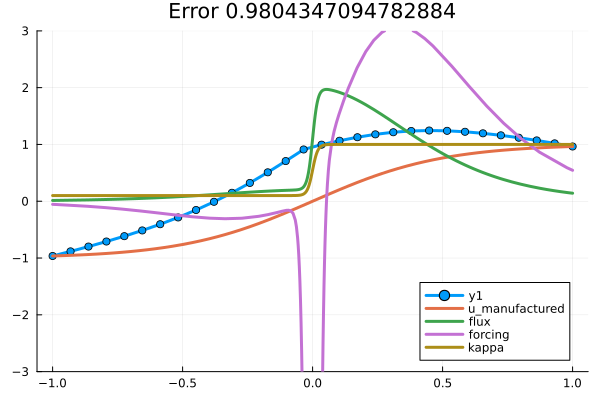

In [9]:
u = L \ rhs
plot(x, u, marker=:circle, legend=:bottomright, title="Error $(norm(u - manufactured.(x), Inf))")
plot!([manufactured flux_manufactured_kappa_tanh forcing_manufactured_kappa_tanh kappa_tanh],
label=["u_manufactured" "flux" "forcing" "kappa"], ylim=(-3, 3))

# MMS Convergence: nondivergence vs conservative

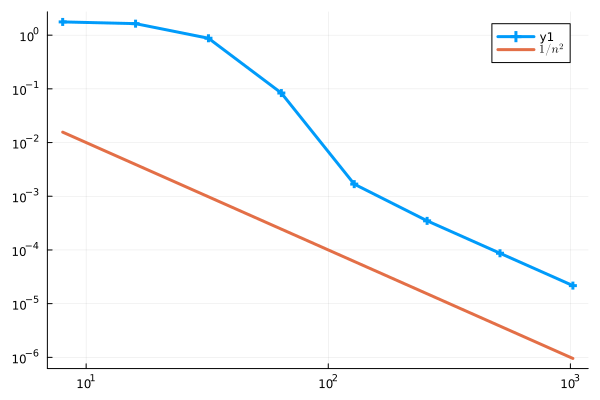

In [11]:
function poisson_error(n, spoints=3)
    x, L, rhs = poisson_conservative(n, kappa_tanh,
        forcing_manufactured_kappa_tanh,
        leftbc=(0, manufactured), rightbc=(0, manufactured))
    u = L \ rhs
    norm(u - manufactured.(x), Inf)
end
ns = 2 .^ (3:10)
plot(ns, poisson_error.(ns, 3), marker=:auto, xscale=:log10, yscale=:log10)
plot!(n -> n^-2, label="\$1/n^2\$")

# Outlook

* Manufactured solutions can be misleading for verification in the presence of rapid coefficient variation.
  * Forcing terms may be poorly resolved on the grid
* Non-conservative methods are scary
  * Can look great during verification on smooth problems, then break catastrophically
* Conservative methods are generally robust, but now we have choices to make
  * What if $\kappa(x)$ is gridded data? How do we evaluate at staggered points?
  * What does this mean for boundary conditions, $\kappa u_x = g$
  * What do staggered points mean on unstructured/adaptive meshes?
  * Which terms should we evaluate where?

# Advection

Advection represents transport in a "wind" $w$. The time-dependent model is
$$ u_t + (w u)_x = 0 $$
for which $u(t,x) = u(0, x - tw)$.

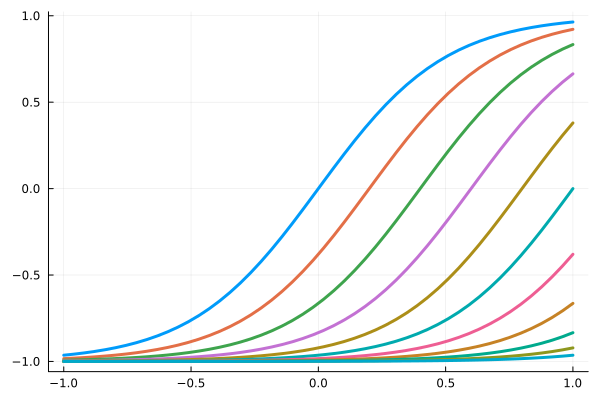

In [5]:
u0(x) = @. tanh(2*x)
usolution(t,x; w=1) = @. u0(x - t*w)
x = LinRange(-1, 1, 50)
plot(x, [usolution(t, x) for t in 0:.2:2], legend=:none)

## What boundary conditions can be specified on the steady-state ($t\to\infty$) problem?

## What is the steady state solution?

# Advection-diffusion with Chebyshev
$$ \underbrace{u_t}_{\text{ignore today}} + \underbrace{(wu)_x}_{\text{advection}} - \underbrace{u_{xx}}_{\text{diffusion}} = \underbrace{f}_{\text{source}} $$

In [38]:
function advdiff_cheb(n, wind, rhsfunc, leftbc=(0, zero), rightbc=(0, zero))
    x = CosRange(-1, 1, n)
    T, dT, ddT = chebdiff(x)
    dT /= T
    ddT /= T
    T /= T
    L = -ddT + wind * dT
    rhs = rhsfunc.(x)
    for (index, deriv, func) in
            [(1, leftbc...), (n, rightbc...)]
        L[index,:] = (T, dT)[deriv+1][index,:]
        rhs[index] = func(x[index])
    end
    x, L, rhs
end

advdiff_cheb (generic function with 3 methods)

minimum(diff(x)) = 0.0032426918657900705


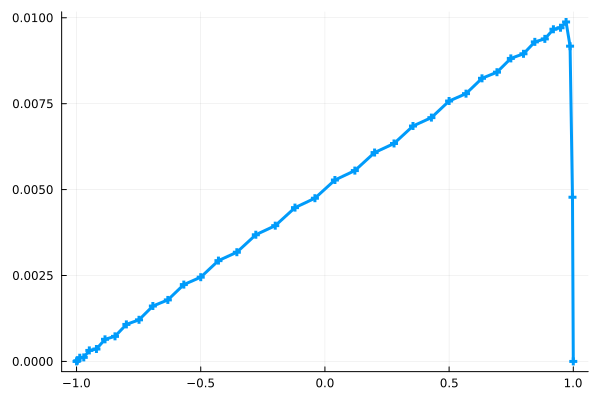

In [57]:
wind = 200
x, L, rhs = advdiff_cheb(40, wind, one)
@show minimum(diff(x))
plot(x, L \ rhs, legend=:none, marker=:auto)

# Advection-diffusion with conservative FD

$$\big(wu - \kappa u_x\big)_x = f$$

In [58]:
function advdiff_conservative(n, kappa, wind, forcing)
    x = LinRange(-1, 1, n)
    xstag = (x[1:end-1] + x[2:end]) / 2
    L = zeros(n, n)
    rhs = forcing.(x)
    kappa_stag = kappa.(xstag)
    for i in 2:n-1
        flux_L = -kappa_stag[i-1] * fdstencil(x[i-1:i], xstag[i-1], 1) + wind * [.5 .5]
        flux_R = -kappa_stag[i] * fdstencil(x[i:i+1], xstag[i], 1) + wind * [.5 .5]
        js = i-1:i+1
        weights = fdstencil(xstag[i-1:i], x[i], 1)
        L[i, i-1:i+1] = weights[1] * [flux_L..., 0] + weights[2] * [0, flux_R...]
    end
    L[1, 1] = 1
    rhs[1] = 0
    L[2:end, 1] .= 0
    L[end,end] = 1
    rhs[end] = 0
    L[1:end-1,end] .= 0
    x, L, rhs
end

advdiff_conservative (generic function with 1 method)

# Experiments, The (cell) [Péclet number](https://en.wikipedia.org/wiki/P%C3%A9clet_number)

\begin{align}
\big(wu - \kappa u_x\big)_x &= f & \mathrm{Pe}_h &= \frac{h \lvert w \rvert}{\kappa}
\end{align}

minimum(diff(x)) = 0.03389830508474567


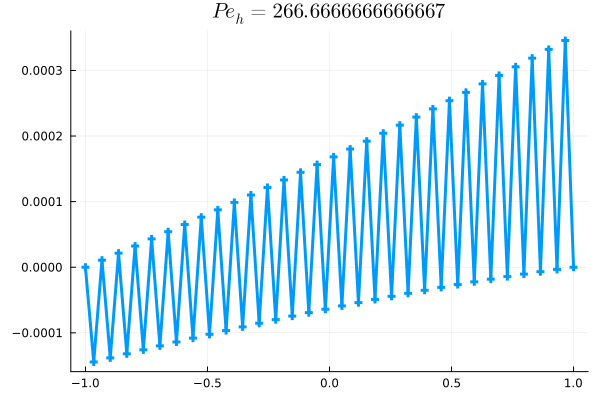

In [68]:
n = 60; h = 2/n
kappa = 1
wind = 8000
x, L, rhs = advdiff_conservative(n, x -> kappa, wind, one)
@show minimum(diff(x))
plot(x, L \ rhs, marker=:auto, legend=:none, title="\$Pe_h = $(wind*h/kappa)\$")

# Upwinded discretization

Idea: incoming **advective flux** should depend only on upwind value, outgoing should depend only on my value.

In [69]:
function advdiff_upwind(n, kappa, wind, forcing)
    x = LinRange(-1, 1, n)
    xstag = (x[1:end-1] + x[2:end]) / 2
    L = zeros(n, n)
    rhs = forcing.(x)
    kappa_stag = kappa.(xstag)
    for i in 2:n-1
        flux_L = -kappa_stag[i-1] * fdstencil(x[i-1:i], xstag[i-1], 1) +
            wind * (wind > 0 ? [1 0] : [0 1])
        flux_R = -kappa_stag[i] * fdstencil(x[i:i+1], xstag[i], 1) +
            wind * (wind > 0 ? [1 0] : [0 1])
        js = i-1:i+1
        weights = fdstencil(xstag[i-1:i], x[i], 1)
        L[i, i-1:i+1] = weights[1] * [flux_L..., 0] + weights[2] * [0, flux_R...]
    end
    L[1, 1] = 1
    rhs[1] = 0
    L[2:end, 1] .= 0
    L[end,end] = 1
    rhs[end] = 0
    L[1:end-1,end] .= 0
    x, L, rhs
end

advdiff_upwind (generic function with 1 method)

# Try it for robustness

minimum(diff(x)) = 0.06896551724137923


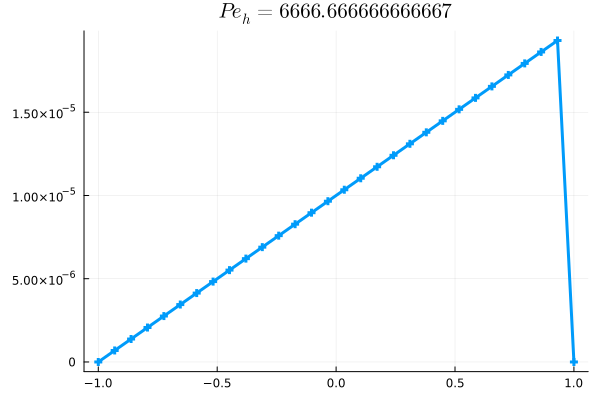

In [75]:
n = 30; h = 2/n
kappa = 1
wind = 100000
x, L, rhs = advdiff_upwind(n, x -> kappa, wind, one)
@show minimum(diff(x))
plot(x, L \ rhs, marker=:auto, legend=:none, title="\$Pe_h = $(wind*h/kappa)\$")

## What is the order of accuracy of the upwinded discretization?

# Godunov's Theorem (1954)

Linear numerical methods
$$ \dot u_i = \sum_j a_{ij} u_j $$
for solving time-dependent PDE can be at most first order accurate if they are monotone.

For our purposes, monotonicity is equivalent to positivity preservation,
$$ \min_x u(0, x) \ge 0 \quad \Longrightarrow \quad \min_x u(t, x) \ge 0 .$$

## Discontinuities

A numerical method for representing a discontinuous function on a stationary grid can be no better than first order accurate in the $L^1$ norm,
$$ \lVert u - u^* \rVert_{L^1} = \int \lvert u - u^* \rvert . $$
If we merely sample a discontinuous function, say
$$ u(x) = \begin{cases} 0, & x \le a \\ 1, & x > a \end{cases} $$
onto a grid with element size $\Delta x$ then we will have errors of order 1 on an interval proportional to $\Delta x$.

In light of these two observations, we may still ask for numerical methods that are more than first order accurate for smooth solutions, but those methods must be nonlinear.

# Next week

* Sparse linear algebra (necessary for more than 1 spatial dimension)
* Nonlinear solvers
* Time integration for stiff and non-stiff systems